# Creating a DESC Equilibrium from a pyQsc Near-Axis Equilibrium

Note that you must have pyQsc installed in order to make use of the `Equilibrium.from_near_axis` method, do so with `pip install qsc`

In [1]:
# must have installed pyQsc with `pip install qsc` in order to use this!
from qsc import Qsc
from desc.equilibrium import Equilibrium
from desc.objectives import get_fixed_boundary_constraints
from desc.plotting import plot_comparison

DESC version 0.7.2+319.g66640f23.dirty,using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 21.62 GB available memory


DESC is able to create an equilibrium based off of a `pyQsc` NAE equilibrium object. First, we'll make the NAE equilibrium using `pyQsc`

In [2]:
qsc_eq = Qsc.from_paper("precise QA")

Then, to make the DESC equilibrium, the `Equilibrium` class has a method `Equilibrium.from_near_axis`. This method creates a DESC `Equilibrium` based off of the `pyQsc` equilibrium. It requires as input the desired DESC FourierZernike resolution, as well as the radius at which you want to evaluate the qsc equilibrium at to make the DESC equilibrium's boundary. The equilibrium's initial `R_lmn`, `Z_lmn` Fourier-Zernike coefficients are fit to the `R,Z` evaluated from the `pyQsc` equilibrium, and the initial `L_lmn` are 0 (because the `pyQsc` equilibrium uses Boozer angles, so there is no poloidal stream function)

In [3]:
ntheta = 75
r = 0.15
desc_eq = Equilibrium.from_near_axis(
    qsc_eq,  # the Qsc equilibrium object
    r=r,  # the finite radius (m) at which to evaluate the Qsc surface to use as the DESC boundary
    L=8,  # DESC radial resolution
    M=8,  # DESC poloidal resolution
    N=8,  # DESC toroidal resolution
    ntheta=ntheta,
)
eq_fit = desc_eq.copy()  # copy so we can see the original Qsc surfaces later

Now we solve the equilibrium as normal in DESC

In [4]:
# get the fixed-boundary constraints, which include also fixing the pressure and fixing the current profile (iota=False flag means fix current)
constraints = get_fixed_boundary_constraints(iota=False)
print(constraints)

# solve the equilibrium
desc_eq.solve(
    verbose=3,
    ftol=1e-2,
    objective="force",
    maxiter=100,
    xtol=1e-6,
    constraints=constraints,
)

# Save equilibrium as .h5 file
desc_eq.save("DESC_from_NAE_precise_QA_output.h5")

(<desc.objectives.linear_objectives.FixBoundaryR object at 0x7fa1f81a2f40>, <desc.objectives.linear_objectives.FixBoundaryZ object at 0x7fa1f81a22b0>, <desc.objectives.linear_objectives.FixLambdaGauge object at 0x7fa1f81a26a0>, <desc.objectives.linear_objectives.FixPsi object at 0x7fa1f81a2790>, <desc.objectives.linear_objectives.FixPressure object at 0x7fa1f81a29a0>, <desc.objectives.linear_objectives.FixCurrent object at 0x7fa1f81a25b0>)
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 329 ms
Timer: Objective build = 2.29 sec
Timer: Linear constraint projection build = 4.65 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 4.00 sec
Timer: Jacobian compilation time = 10.3 sec
Timer: Total compilation time = 14.4 sec
Number of parameters: 848
Number of objectives: 5346
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4580

Now we have a DESC equilibrium solved with the boundary from `pyQsc`. It has zero toroidal current as its profile constraint along with zero pressure since the original Qsc equilibrium had 0 pressure and current.

(<Figure size 864x864 with 2 Axes>,
 array([<AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:title={'center':'$\\zeta \\cdot NFP/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

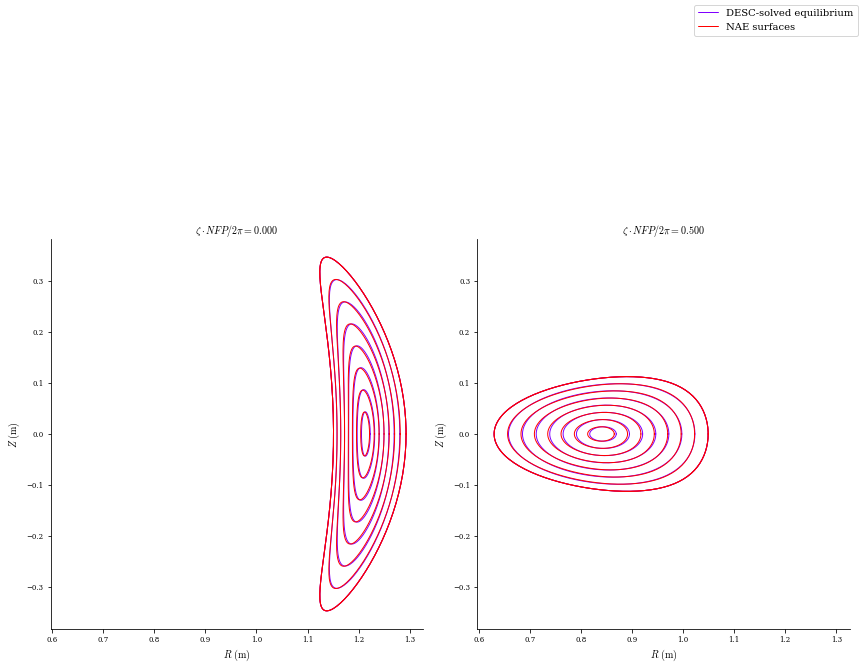

In [6]:
plot_comparison(
    eqs=[desc_eq, eq_fit],
    labels=["DESC-solved equilibrium", "NAE surfaces"],
    zeta=2,
    figsize=(12, 12),
    theta=0,
)